In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
scripts_dir = os.path.abspath(os.path.join(parent_dir, "scripts"))
sys.path.append(scripts_dir)
import ipyparallel as ipp
import metrics as met
import models as mod
import numpy #as np
import pandas #as pd
import scipy.stats as st
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import get_context
from plotnine import *
from scipy.integrate import quad
from scipy.stats._distn_infrastructure import rv_continuous_frozen
from typing import Dict, Tuple

In this notebook, we shall conduct simulations to evaluate the predictive performance of extreme event predictors based on various density ratio estimators. Data will first be generated from the model $Y = X^{\top}\beta + \epsilon$, where $\beta \in \mathbb{R}^d$, and we will initially assume that $X \sim \mathcal{N}_d(0, \Sigma)$, $\epsilon \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$, and $X \perp\!\!\!\perp \epsilon$. By Remark 2.8 in [our paper](https://arxiv.org/pdf/2407.11887), for any $p \in (0, 1)$, the optimal predictor of $\{Y > F_Y^{-1}(p)\}$ is $\{X^{\top}\beta > F_{X^{\top}\beta}^{-1}(p)\}$.

We first define a function `calc_opt_precision` that computes the precision of the optimal predictor for the special case in which $Y = X + \epsilon$, where $X \sim \mathcal{N}(0, \sigma_X^2)$, $\epsilon \sim \mathcal{N}(0, \sigma_{\epsilon}^2)$, and $X \perp\!\!\!\perp \epsilon$. The optimal predictor in this case is $\{X > F_X^{-1}(p)\}$, so the optimal precision is $\mathbb{P}(Y > F_Y^{-1}(p) \mid X > F_X^{-1}(p))$. We have
$$
    \mathbb{P}(Y > F_Y^{-1}(p) \mid X > F_X^{-1}(p)) = \frac{\mathbb{P}(Y > F_Y^{-1}(p), X > F_X^{-1}(p))}{\mathbb{P}(X > F_X^{-1}(p))} = \frac{\mathbb{P}(Y > F_Y^{-1}(p), X > F_X^{-1}(p))}{1 - p}.
$$ (eq:precision)
The numerator of the last fraction in {eq}`eq:precision` can be written as
$$
    \int_{F_X^{-1}(p)}^{\infty} \mathbb{P}(Y > F_Y^{-1}(p) \mid X = x)f_X(x)\,dx,
$$ (eq:numer_prob)
where $f_X$ is the density of $X$. We have
$$
    \mathbb{P}(Y > F_Y^{-1}(p) \mid X = x)
    = \mathbb{P}(X + \epsilon > F_Y^{-1}(p) \mid X = x)
    = \mathbb{P}(x + \epsilon > F_Y^{-1}(p) \mid X = x)
    = \mathbb{P}(\epsilon > F_Y^{-1}(p) - x)
    = F_{\epsilon}(x - F_Y^{-1}(p)),
$$ (eq:cond_prob)
where $F_{\epsilon}$ is the distribution function of $\epsilon$. Using {eq}`eq:numer_prob` and {eq}`eq:cond_prob`, we can rewrite the last fraction in {eq}`eq:precision` as
$$
    \frac{1}{1 - p}\int_{F_X^{-1}(p)}^\infty F_{\epsilon}(x - F_Y^{-1}(p))f_X(x)\,dx.
$$
The quantile $F_Y^{-1}(p)$ is simple to calculate since $Y \sim \mathcal{N}(0, \sigma_X^2 + \sigma_{\epsilon}^2)$.

Note that we can easily obtain from this a formula for the optimal precision in the general case where $Y = X^{\top}\beta + \epsilon$. Recall that the optimal predictor is $\{X^{\top}\beta > F_{X^{\top}\beta}^{-1}(p)\}$. Since $X^{\top}\beta \sim \mathcal{N}(0, \beta^{\top}\Sigma\beta)$, and $X^{\top}\beta \perp\!\!\!\perp \epsilon$, the optimal precision is
$$
    \mathbb{P}(Y > F_Y^{-1}(p) \mid X^{\top}\beta > F_{X^{\top}\beta}^{-1}(p)) = \frac{1}{1 - p}\int_{F_{X^{\top}\beta}^{-1}(p)}^\infty F_{\epsilon}(x - F_Y^{-1}(p))f_{X^{\top}\beta}(x)\,dx.
$$

In [2]:
def calc_opt_precision(x_sd: float, epsilon_sd: float, p: float) -> float:
    """
    Calculate P(Y > F_Y^{-1}(p) | X > F_X^{-1}(p)), the precison of {X > F_X^{-1}(p)}, the optimal predictor of {Y > F_Y^{-1}(p)} when Y = X + epsilon,
    with X and epsilon being independent mean zero normal random variables.

    :param x_sd: Float; standard deviation of X.
    :param epsilon_sd: Float; standard deviation of epsilon.
    :param p: Float; the quantile level that defines extremeness.
    :return: Float; the precision of the optimal predictor.
    """
    if not isinstance(x_sd, float):
        raise TypeError("x_sd must be a float")
    if x_sd <= 0:
        raise ValueError("x_sd must be positive")
    if not isinstance(epsilon_sd, float):
        raise TypeError("epsilon_sd must be a float")
    if epsilon_sd <= 0:
        raise ValueError("epsilon_sd must be positive")

    q_x = st.norm.ppf(p, scale=x_sd)
    q_y = st.norm.ppf(p, scale=numpy.sqrt(x_sd ** 2 + epsilon_sd ** 2))
    def calc_integrand(x):
        return st.norm.cdf(x - q_y, scale=epsilon_sd) * st.norm.pdf(x, scale=x_sd)
    numer_prob, _ = quad(calc_integrand, q_x, numpy.inf)
    return numer_prob / (1 - p)

The function `make_dataset` generates a random sample from the joint distribution of $X$ and $Y$ under the model $Y = X^{\top}\beta + \epsilon$, for user-specified distributions of $X$ and $\epsilon$. Those distributions aren't required to be Gaussian.

In [3]:
def make_dataset(x_dist, epsilon_dist: rv_continuous_frozen, beta: numpy.ndarray, n: int, rng=None) -> Tuple[numpy.ndarray, numpy.ndarray]:
    """
    Generate a random sample from the joint distribution of X and Y, where Y = X.T @ beta + epsilon.

    :param x_dist: Frozen multivariate random vector; the distribution of X.
    :param epsilon_dist: Frozen random variable; the distribution of epsilon.
    :param beta: NumPy array of shape (d,); the vector of model coefficients.
    :param n: Integer; the sample size.
    :param rng: the random state.
    :return: Tuple of NumPy arrays of shapes (n, d) and (n,); the matrix of observations on X and the vector of observations on Y.
    """
    if not isinstance(epsilon_dist, rv_continuous_frozen):
        raise TypeError("epsilon_dist must be an instance of scipy.stats._distn_infrastructure.rv_continuous_frozen")
    if not isinstance(beta, numpy.ndarray):
        raise TypeError("beta must be a NumPy array")
    if beta.ndim != 1:
        raise TypeError("beta must be 1D")
    if not isinstance(n, int):
        raise TypeError("n must be an integer")
    if n <= 0:
        raise ValueError("n must be positive")

    x = x_dist.rvs(size=n, random_state=rng) # could try uniform as well? look at lasso literature
    x = numpy.atleast_2d(x)
    if x.shape[1] != beta.size:
        x = x.reshape(-1, beta.size)
    epsilon = epsilon_dist.rvs(size=n, random_state=rng) # could try different distributions here, like t
    y = x @ beta + epsilon

    return x, y

The next function plots $Y$ versus $X^{\top}\beta$ for observations generated from the model $Y = X^{\top}\beta + \epsilon$.

In [4]:
def plot_dataset(beta: numpy.ndarray, x: numpy.ndarray, y: numpy.ndarray) -> ggplot:
    """
    Plot Y versus X.T @ beta for observations generated from the model Y = X.T @ beta + epsilon.    

    :param beta: NumPy array of shape (d,); the vector of model coefficients.
    :param x: NumPy array of shape (n, d); the matrix containing the observations on X.
    :param y: NumPy array of shape (n,); the vector containing the observations on Y.
    :return: ggplot; the plot of Y versus X.T @ beta.
    """
    if not isinstance(beta, numpy.ndarray):
        raise TypeError("beta must be a NumPy array")
    if beta.ndim != 1:
        raise TypeError("beta must be 1D")
    if not isinstance(x, numpy.ndarray):
        raise TypeError("x must be a NumPy array")
    if x.ndim != 2:
        raise TypeError("x must be 2D")    
    if not isinstance(y, numpy.ndarray):
        raise TypeError("y must be a NumPy array")
    if y.ndim != 1:
        raise TypeError("y must be 1D")

    return (
        ggplot(data=pandas.DataFrame({"lin_pred": x @ beta, "y": y}), mapping=aes(x="lin_pred", y="y"))
        + geom_point()
        + geom_abline(slope=1, intercept=0)
        + labs(x=r"$X^{\top}\beta$", y="Y", caption=r"$Y = X^{\top}\beta$ along the line")
        + theme_bw()
    )

We test the functions `make_dataset` and `plot_dataset`:

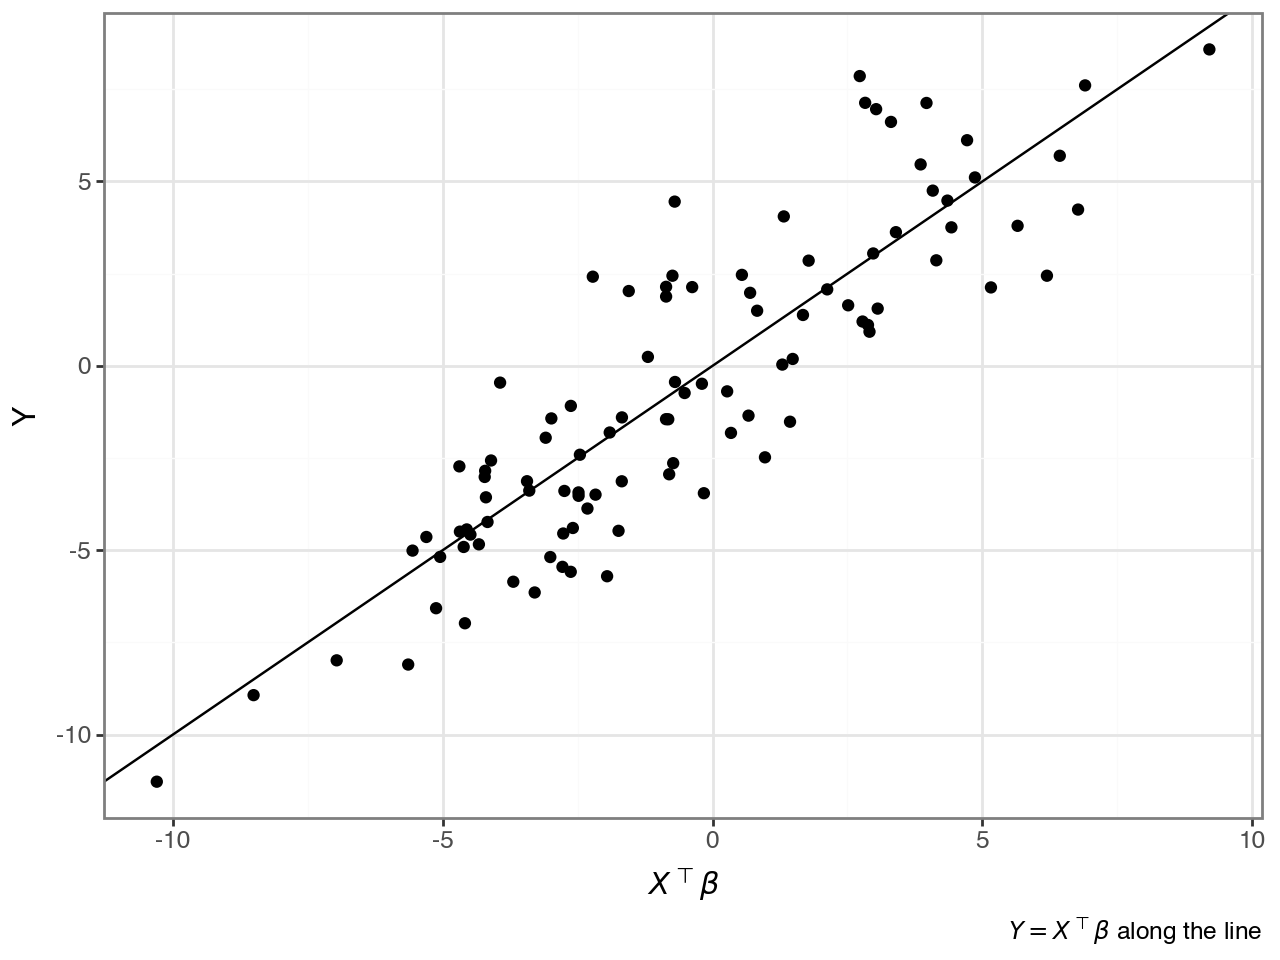

In [5]:
rng = numpy.random.default_rng()
d = 6
r = 4
a = numpy.reshape(st.norm.rvs(size=d * r, random_state=rng), (d, r))
x_dist = st.multivariate_normal(cov=a @ a.T, allow_singular=True)
epsilon_sd = 2
epsilon_dist = st.norm(scale=epsilon_sd)
beta = numpy.ones(d)
n = 100
x, y = make_dataset(x_dist, epsilon_dist, beta, n, rng)
plot_dataset(beta, x, y)

The function `calc_opt_precision` is only usable when $X$ and $\epsilon$ are Gaussian. If they aren't both Gaussian, then the optimal precision must be estimated. We can estimate it be generating many pairs $(X_1, Y_1), \ldots, (X_n, Y_n)$ and computing
$$
    \frac{\frac{1}{n}\sum_{i = 1}^n \mathbb{I}(X_i > \widehat{F}_{X^{\top}\beta}^{-1}(p), Y_i > \widehat{F}_Y^{-1}(p))}{\frac{1}{n}\sum_{i = 1}^n \mathbb{I}(X_i > \widehat{F}_{X^{\top}\beta}^{-1}(p))},
$$
where $\mathbb{I}$ represents an indicator function and $\widehat{F}_{X^{\top}\beta}^{-1}(p)$ and $\widehat{F}_Y^{-1}(p)$ are the $p$-th samples quantiles of $X^{\top}\beta$ and $Y$, respectively. The function below calculates those quantiles.

In [6]:
def calc_true_quantiles(x_dist, epsilon_dist: rv_continuous_frozen, beta: numpy.ndarray, n: int, p: float, rng=None) -> Tuple[float, float]:
    """
    Calculate (estimate, really) the true pth quantiles of the linear predictor and the response for the model Y = X.T @ beta + epsilon.

    :param x_dist: Frozen multivariate random vector; the distribution of X.
    :param epsilon_dist: Frozen random variable; the distribution of epsilon.
    :param beta: NumPy array of shape (d,); the vector of model coefficients.
    :param n: Integer; the sample size.
    :param p: Float; the quantile level that defines extremeness.
    :param rng: the random state.
    :return: Tuple of floats; the pth quantiles of the linear predictor and the response.
    """
    x, y = make_dataset(x_dist, epsilon_dist, beta, n, rng=rng)
    lin_pred = x @ beta
    lin_pred_quantile = numpy.quantile(lin_pred, p, method="inverted_cdf")
    y_quantile = numpy.quantile(y, p, method="inverted_cdf")
    return lin_pred_quantile, y_quantile

We test `calc_true_quantiles` using the same objects that were used to test `make_dataset` and `plot_dataset`.

In [7]:
p = 0.95
lin_pred_quantile = st.norm.ppf(p, scale=numpy.sqrt(beta.T @ a @ a.T @ beta))
y_quantile = st.norm.ppf(p, scale=numpy.sqrt(beta.T @ a @ a.T @ beta + epsilon_sd ** 2))
print(lin_pred_quantile, y_quantile)
calc_true_quantiles(x_dist, epsilon_dist, beta, 1000000, p, rng)

5.286508737342413 6.226503709657558


(5.286201663631539, 6.237067567332952)

The following function generates a dataset using `make_dataset` and evaluates the performance of given predictors on it. It also evaluates the performance of the optimal predictor $\{X^{\top}\beta > F_{X^{\top}\beta}^{-1}(p)\}$, which is referred to as the oracle.

In [8]:
def do_1_run(dists, beta: numpy.ndarray, sizes: Dict, quantiles: Dict, mods, metrics, rng=None) -> pandas.DataFrame:
    """

    :param dists:
    :param beta:
    :param sizes:
    :param quantiles:
    :param mods:
    :param metrics:
    :param rng:
    :return: Pandas DataFrame
    """
    x_dist, epsilon_dist = dists["x"], dists["epsilon"]
    train_size, test_size = sizes["train"], sizes["test"]
    lin_pred_quantile, y_quantile = quantiles["lin_pred"], quantiles["y"]

    x, y = make_dataset(x_dist, epsilon_dist, beta, train_size + test_size, rng)
    x_train, y_train = x[:train_size], y[:train_size] > y_quantile
    x_test, y_test = x[train_size:], y[train_size:] > y_quantile

    mod_summaries = []
    for mod in mods:
        mod.fit(x_train, y_train)
        mod_preds = mod.predict(x_test)
        mod_summary = {metric.__class__.__name__: metric.evaluate(y_test, mod_preds) for metric in metrics}
        mod_summary = pandas.DataFrame([mod_summary])
        mod_summary.insert(0, "mod", mod.__class__.__name__)
        mod_summaries.append(mod_summary)

    oracle_preds = x_test @ beta >= lin_pred_quantile
    oracle_summary = {metric.__class__.__name__: metric.evaluate(y_test, oracle_preds) for metric in metrics}
    oracle_summary = pandas.DataFrame([oracle_summary])
    oracle_summary.insert(0, "mod", "oracle")
    mod_summaries.append(oracle_summary)

    return pandas.concat(mod_summaries).reset_index(drop=True)

We test `do_1_run` with the same objects that we've been using for testing:

In [9]:
dists = {"x": x_dist, "epsilon": epsilon_dist}
sizes = {"train": 10000, "test": 10000}
quantiles = {"lin_pred": lin_pred_quantile, "y": y_quantile}

k_numer = 100
k_denom = 900
mod1 = mod.KNNModel(k_numer, k_denom, p)
k = k_numer + k_denom
mod2 = mod.KNN2Model(k, p)
mods = [mod1, mod2]

metrics_ = [met.tpr(), met.fpr(), met.precision(), met.tss()]

do_1_run(dists, beta, sizes, quantiles, mods, metrics_)

,mod,tpr,fpr,precision,tss
0,KNNModel,0.535070,0.025260,0.526627,0.509810
1,KNN2Model,0.553106,0.024418,0.543307,0.528688
2,oracle,0.581162,0.021050,0.591837,0.560112


The precision of the oracle predictor should be close to the optimal precision as given by `calc_opt_precision`:

In [10]:
opt_precision = calc_opt_precision(x_sd=numpy.sqrt(beta.T @ x_dist.cov @ beta), epsilon_sd=epsilon_dist.std(), p=p)
opt_precision

0.5579198158345662

The function below runs `do_1_run` `num_runs` times using `max_workers` engines or worker processes. It can be used to run experiments in a Jupyter notebook.

In [11]:
def simulate(num_runs, max_workers, dists: Dict, beta: numpy.ndarray, sizes: Dict, quantiles: Dict, mods, metrics_, rng) -> pandas.DataFrame:
    child_rngs = rng.spawn(num_runs)
    with ipp.Cluster(n=max_workers) as rc:
        e_all = rc[:]
        e_all.use_dill()
        with e_all.sync_imports():
            import os
            import sys
        e_all.execute("parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))", block=True)
        e_all.execute("scripts_dir = os.path.abspath(os.path.join(parent_dir, 'scripts'))", block=True)
        e_all.execute("sys.path.append(scripts_dir)", block=True)
        with e_all.sync_imports():
            import numpy
            import pandas
            from scipy.stats._distn_infrastructure import rv_continuous_frozen
            from typing import Dict, Tuple
        e_all.push({
            "make_dataset": make_dataset, "do_1_run": do_1_run, "dists": dists, "beta": beta, "sizes": sizes, "quantiles": quantiles, "mods": mods, "metrics_": metrics_,
            "child_rngs": child_rngs
        })
        ar = e_all.map_sync(lambda i: do_1_run(dists, beta, sizes, quantiles, mods, metrics_, child_rngs[i]).assign(run_num=i), range(num_runs))
    results = pandas.concat(ar).reset_index(drop=True)
    run_nums = results.pop("run_num")
    results.insert(0, "run_num", run_nums)
    return results

The function below does the same thing as `simulate`. It can be used to run experiments in a script.

In [12]:
def simulate2(num_runs, max_workers, dists: Dict, beta: numpy.ndarray, sizes: Dict, quantiles: Dict, mods, metrics_, rng) -> pandas.DataFrame:
    child_rngs = rng.spawn(num_runs)
    summaries = []
    with ProcessPoolExecutor(max_workers, mp_context=get_context("fork")) as executor:
        futures = [executor.submit(do_1_run, dists, beta, sizes, quantiles, mods, metrics_, child_rngs[i]) for i in range(num_runs)]
        for future in as_completed(futures):
            summaries.append(future.result())
    return pandas.concat(summaries).reset_index(drop=True)

Test:

In [13]:
num_runs = 24
max_workers = 8
rng = numpy.random.default_rng()
results = simulate(num_runs, max_workers, dists, beta, sizes, quantiles, mods, metrics_, rng)
results

Starting 8 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 8/8 [00:10<00:00,  1.37s/engine]
importing os on engine(s)
importing sys on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing rv_continuous_frozen from scipy.stats._distn_infrastructure on engine(s)
importing Dict,Tuple from typing on engine(s)
Stopping engine(s): 1728449710
engine set stopped 1728449710: {'engines': {'0': {'exit_code': 0, 'pid': 61825, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 61826, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 61827, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 61828, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 61829, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 61830, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 61839, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 61859, 'identifier': '7'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 61783, 'identifier'

,run_num,mod,tpr,fpr,precision,tss
0,0,KNNModel,0.493384,0.025657,0.517857,0.467726
1,0,KNN2Model,0.504726,0.025235,0.527668,0.479491
2,0,oracle,0.568998,0.022490,0.585603,0.546508
3,1,KNNModel,0.444898,0.021977,0.510539,0.422921
4,1,KNN2Model,0.465306,0.019979,0.545455,0.445327
...,...,...,...,...,...,...
67,22,KNN2Model,0.558233,0.029047,0.501805,0.529186
68,22,oracle,0.568273,0.025363,0.540076,0.542910
69,23,KNNModel,0.461078,0.027687,0.467611,0.433391
70,23,KNN2Model,0.489022,0.026108,0.496957,0.462914


Make a boxplot of the metric values for each metric:

In [14]:
def plot_results(results: pandas.DataFrame, opt_precision: float = None) -> ggplot:
    results2 = pandas.melt(results, id_vars=["run_num", "mod"], var_name="metric", value_name="val")
    plot = (
        ggplot(data=results2, mapping=aes(x="mod", y="val"))
        + facet_wrap("metric")
        + geom_boxplot()
        + labs(x="Model", y="Value", caption="Dashed line is at optimal precision")
        + theme_bw()
    )
    if opt_precision is not None:
        plot = plot + geom_hline(yintercept=opt_precision, linetype="dashed")
    return plot

Test:

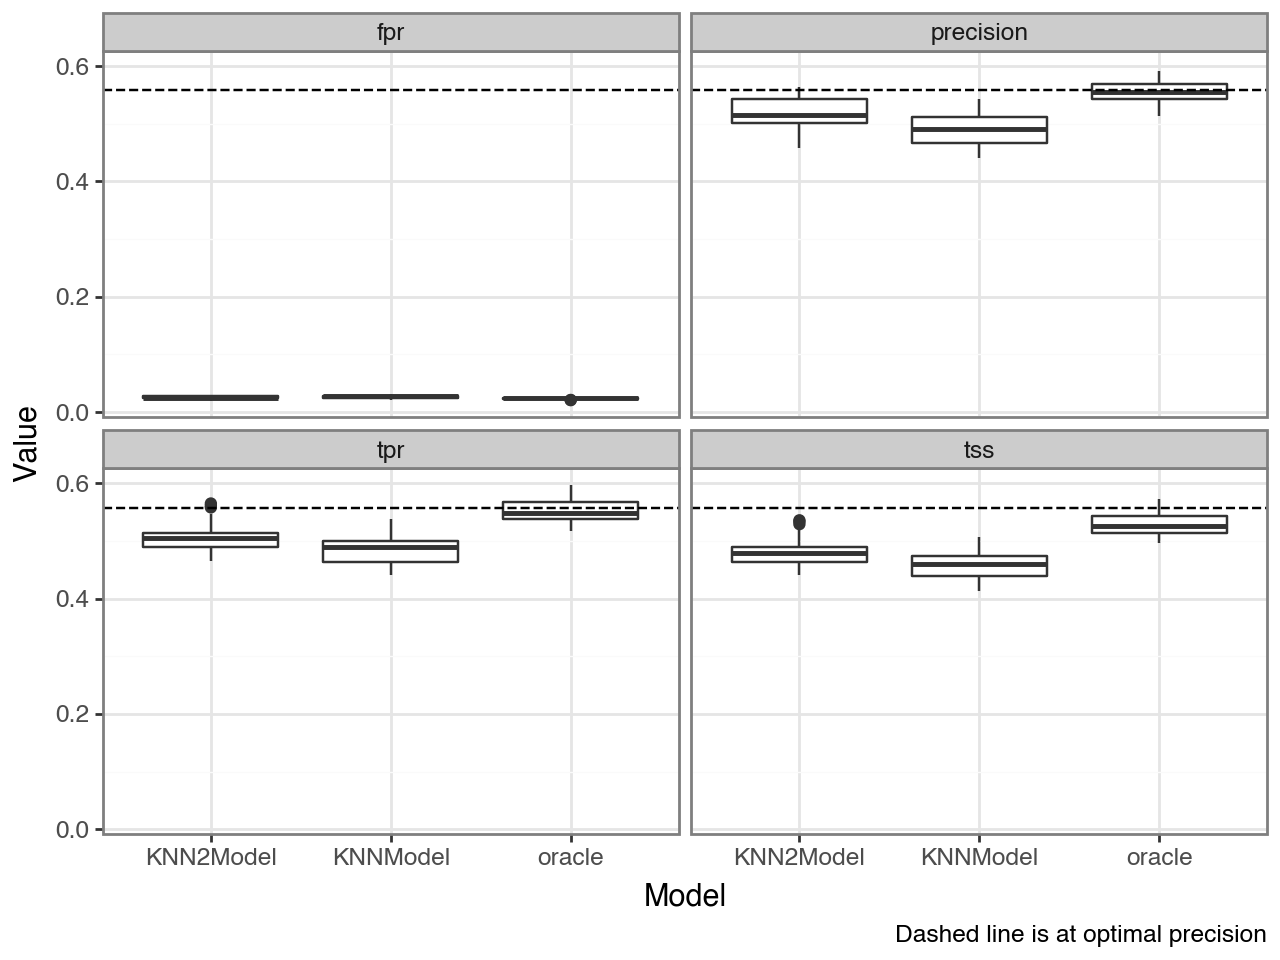

In [15]:
plot_results(results, opt_precision)

In [16]:
import subprocess

subprocess.run([
    "jupyter", "nbconvert",
    "--no-prompt",
    "--to", "script",
    "--output-dir", "../scripts/",
    "--TagRemovePreprocessor.enabled", "True",
    "--TagRemovePreprocessor.remove_cell_tags", "exclude",
    "sim_funs.ipynb"
])

[NbConvertApp] Converting notebook sim_funs.ipynb to script
[NbConvertApp] Writing 9602 bytes to ../scripts/sim_funs.py


CompletedProcess(args=['jupyter', 'nbconvert', '--no-prompt', '--to', 'script', '--output-dir', '../scripts/', '--TagRemovePreprocessor.enabled', 'True', '--TagRemovePreprocessor.remove_cell_tags', 'exclude', 'sim_funs.ipynb'], returncode=0)